In [2]:
import cv2
import pytesseract
#import csv
import numpy as np
import pandas as pd
from ultralytics import YOLO
import textract
#from PIL import Image
import matplotlib.pyplot as plt
import keras_ocr
import Levenshtein
from skimage.filters import threshold_local
import easyocr

In [3]:
text_reader = easyocr.Reader(['en']) #Initialzing the ocr
config = f'--psm 6'
pipeline = keras_ocr.pipeline.Pipeline()

Looking for C:\Users\Flam\.keras-ocr\craft_mlt_25k.h5
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Looking for C:\Users\Flam\.keras-ocr\crnn_kurapan.h5


In [4]:
def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255
#function to enhance the contrast of image for better ocr result
def enhance(im):
    img1 = cv2.imread(im)
    img = bw_scanner(img1)
    # converting to LAB color space
    img=cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    # feel free to try different values for the limit and grid size:
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(9,9))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))

    # Converting image from LAB Color model to BGR color spcae
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    # Stacking the original image with the enhanced image
    #result = np.hstack((img, enhanced_img))
    #cv2.imshow('Result', result)
    #cv2.waitKey(0)
    return enhanced_img

In [5]:
# extracting bounding boxes cordinates and their labels
def boxes_labels(results,x,y,h,w,c):
    bbox=results[0].boxes.boxes
    bbox=bbox.cpu().numpy()
    boxes=results[0].boxes.xyxy
    for i,box in enumerate(boxes):
        box=box.cpu().numpy()
        print("fragment ",i," :",box)
        x.append(int(box[0]))
        y.append(int(box[1]))
        h.append(int(box[3]-y[i]))
        w.append(int(box[2]-x[i]))
        c.append(bbox[i][5])

In [6]:
#storing ROIs in a liste
def crop_image(x,y,h,w):
    cropped=[]
    for (X,Y,H,W) in zip(x,y,h,w):
        cropped.append(img[Y:Y+H, X:X+W])
    print("cropped images: ",len(cropped))
    return (cropped)

In [7]:
#to avoid the presence of multi instance from classes
def singilarity(cropped,c,classes,images):
   # images=[]
    for (img,C) in zip(cropped,c):
        try:
            i=classes.index(C)
        except:
            i=-1
        if i<0 :
            classes.append(C)
            images.append(img)
        else :
            if len(img)>len(images[i]) :
                images[i]=img
    print('number of images:',len(images),'number of classes',len(classes))
            

In [93]:
#cleaning strings
def strip_string(my_string):
    replacements = [('!', ''), ('?', ''),('|',''),("[",""),("]",""),('\\',""),('\r',''),('\'',''),('.',''),('',''),("\u200f",""),("\u200e",""),("{",""),("}",""),("%",""),("~",""),(",","."),(':','.'),(";","."),('°',''),('+',''),('(',''),(')','')]
    for char, replacement in replacements:
        if char in my_string:
            my_string = my_string.replace(char, replacement)
    return my_string

def prepare(my_string,flag):
    tmp=strip_string(my_string)
    tmp=tmp.split("\n")
    while("" in tmp):
        tmp.remove("")
    return(tmp)

def remove_substring_except_last(string, substring):
    # Replace all occurrences of the substring except the last one with an empty string
    new_string = string.replace(substring, "", string.count(substring)-1)
    # Split the string at the last occurrence of the substring
    parts = new_string.rsplit(substring, 1)
    # Join the parts back together with the substring
    return substring.join(parts)

def reglage_montant(money):
    for i in range(len(money)):
        money[i]=remove_substring_except_last(money[i],'.')
    return (money)

def get_numbers(test_string):
    letter = [x for x in test_string]
    res = [i for i in letter if (i.isdigit() or i=='.')]
    result=''.join(res)
    if (len(result)>0):
        return result
    else:
        return (test_string)
def containsNumber(value):
    for character in value:
        if character.isdigit():
            return True
    return False
def number_correction(string):
    corrected=[]
    replacements = [("Q","0"),("p","0"),("q","0"),("d","0"),("o","0"),("O","0"),('I','1'),('z','2'),('Z','2'),('a','3'),(" ",""),("B","8")]
    X=string.split(" ")
    for i in X:
        letters=i
        for char, replacement in replacements:
            if char in letters:
                letters = letters.replace(char, replacement)
        corrected.append(letters)
    ss=" ".join(corrected)
    return (ss)

In [94]:
#Return the best result from three ocr results
def best_res(string1,string2,string3,maxi_letters=False):
    empty=0
    for x in [string1,string2,string3]:
        if x =='':
            empty+=1
        else:
            unique=x
    if empty==3:
        return "0";
    if empty==2:
        return unique
    # Define the three OCR strings
    flag=False
    if (string1==''):
        flag=True
        #string1='0123456789.-'
    if(string2==''):
        if (flag==True):
            flag=False
            string2='0123456789.-'
    if(string3==''):
        if (flag==True):
            flag=False
            string3='0123456789.-'
    ocr_strings = [string1,string2,string3]
    #print('st1:',string1,'st2:',string2,'st3:',string3)
    # Calculate the average Levenshtein distance between each OCR string and the other two strings
    avg_distances = []
    for i in range(len(ocr_strings)):
        total_distance = 0
        for j in range(len(ocr_strings)):
            if i != j:
                total_distance += Levenshtein.distance(ocr_strings[i], ocr_strings[j])
        avg_distance = total_distance / 2
        avg_distances.append(avg_distance)
    if(maxi_letters==True):
        ind=unique_long(ocr_strings)
        if(ind>-1):
            avg_distances[ind]=avg_distances[ind]-2

    # Determine the most accurate result based on the average distances
    #if min(avg_distances) < 4:
    index = avg_distances.index(min(avg_distances))
    if len(ocr_strings[index])>0:
        return (ocr_strings[index])
    else:
        return('error')
    #else:
        #return ('not reliable')


In [18]:
def divide_image(im):
    image = cv2.imread(im)

    height, width = image.shape[:2]
    midpoint = width // 2

    left_image = image[:, :midpoint].copy()
    right_image = image[:, midpoint:].copy()
    return([left_image,right_image])

In [10]:
def easy_oc(image):
    results = text_reader.readtext(image )
    textt=[]
    for (bbox, text, prob) in results:
        textt.append(text)
    easy_res=''.join(textt)
    return easy_res

In [11]:
def perform_ocr(ocr_im,max_letters):
    res_keras=[]
    corrected=[]
    res_tes=[]
    tt=cv2.imread(ocr_im)
    res_tes=pytesseract.image_to_string(tt,config=config,lang='exp_1')
    res_tes=prepare(res_tes,'tab')
    res_tes=number_correction(res_tes)
    print(res_tes)
    res_opus=textract.process(ocr_im,method='ocropus')
    res_opus=res_opus.decode("utf-8")
    res_opus=prepare(res_opus,'tab')
    res_opus=number_correction(res_opus)
    res_opus=res_opus.replace(" ","")
    print(res_opus)
    res_easy=easy_oc(tt)
    res_easy=number_correction(res_easy)
    #predictions = pipeline.recognize([tt])
    #for prediction in predictions[0]:
     #   res_keras.append(prepare(prediction[0],'tab'))
    #res_keras=' '.join(res_keras)
    #if (check==True):
     #   if("." not in res_keras):
      #      res_keras=''
    print(res_easy)
    best=best_res(res_tes,res_opus,res_easy,maxi_letters=max_letters)
    best_s=best.split()
    return (best_s)

In [64]:
#Loading the image on which we are going to perfom ocr
image='D4/ss/7.png'
img=cv2.imread(image,0)
img.shape

(2338, 1654)

In [65]:
# Load a model
cells = YOLO("weights/MT_elect_v1.pt")# load the table cells detection model
# detecting the 3 main region of interests within the invoice
results_tab = cells(image)  # predict on an image

Ultralytics YOLOv8.0.22  Python-3.9.12 torch-1.13.1 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
Model summary (fused): 168 layers, 11128293 parameters, 0 gradients, 28.5 GFLOPs
image 1/1 C:\Users\Flam\Desktop\Stage WCT\D4\ss\7.png: 640x480 1 bonus, 1 consommation, 1 num-date, 1 penalty, 1 periodique, 1 ref, 1 triphase, 18.7ms
Speed: 0.0ms pre-process, 18.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


In [66]:
#Extracting bounding boxes and ROI from the table model
x=[]
y=[]
h=[]
w=[]
c=[]
cropped=[]
boxes_labels(results_tab,x,y,h,w,c)
cropped=crop_image(x,y,h,w)
classes=[]
images=[]
singilarity(cropped,c,classes,images)


fragment  0  : [       1040         918        1436        1082]
fragment  1  : [       1275         546        1450         673]
fragment  2  : [        337        1160         536        1329]
fragment  3  : [       1033         689        1435         923]
fragment  4  : [        452         176        1126         304]
fragment  5  : [         54        1429         655        1478]
fragment  6  : [         61        1380         649        1451]
cropped images:  7
number of images: 7 number of classes 7


In [67]:
#storing cropped images locally
exceptions=[0,0,0,0,0,0,0]
try:
    cv2.imwrite('D4/frags/bon.jpg', images[classes.index(0)])
    cv2.imwrite('D4/frags/bonus.jpg', enhance('D4/frags/bon.jpg'))
except:
    exceptions[0]=1
try:    
    cv2.imwrite('D4/frags/con.jpg', images[classes.index(1)])
    cv2.imwrite('D4/frags/consommation.jpg', enhance('D4/frags/con.jpg'))
except:
    exceptions[1]=1
try:
    cv2.imwrite('D4/frags/n_d.jpg', images[classes.index(2)])
    cv2.imwrite('D4/frags/num_date.jpg', enhance('D4/frags/n_d.jpg'))
    
except:
    exceptions[2]=1
try:
    cv2.imwrite('D4/frags/pen.jpg', images[classes.index(3)])
    cv2.imwrite('D4/frags/penalty.jpg', enhance('D4/frags/pen.jpg'))
except:
    exceptions[3]=1

try:
    cv2.imwrite('D4/frags/per.jpg', images[classes.index(4)])
    cv2.imwrite('D4/frags/periodique.jpg', enhance('D4/frags/per.jpg'))
except:
    exceptions[4]=1
try:
    cv2.imwrite('D4/frags/ref.jpg', images[classes.index(5)])
    cv2.imwrite('D4/frags/reference.jpg', enhance('D4/frags/ref.jpg'))
except:
    exceptions[5]=1
try:
    cv2.imwrite('D4/frags/tri.jpg', images[classes.index(6)])
    cv2.imwrite('D4/frags/triphase.jpg', enhance('D4/frags/tri.jpg'))
except:
    exceptions[6]=1


In [68]:
exceptions

[0, 0, 0, 0, 0, 0, 0]

In [69]:
old_tri,new_tri=divide_image('D4/frags/triphase.jpg')
old_per,new_per=divide_image('D4/frags/periodique.jpg')
cv2.imwrite('D4/frags/old_triphase.jpg',old_tri)
cv2.imwrite('D4/frags/new_triphase.jpg',new_tri)
cv2.imwrite('D4/frags/old_periodique.jpg',old_per)
cv2.imwrite('D4/frags/new_periodique.jpg',new_per)

True

In [ ]:
if(exceptions[0]==0):
    bonus=perform_ocr('D4/frags/bonus.jpg',False)
else:
    bonus=['error']
    
if(exceptions[1]==0):
    consommation=perform_ocr('D4/frags/consommation.jpg',max_letters=False)
else:
    consommation=['0']
    
if(exceptions[2]==0):
    num_date=perform_ocr('num_date.jpg.jpg',max_letters=False)
else:
    num_date=['0']
    
if(exceptions[3]==0):
    penalty=perform_ocr('D4/frags/penalty.jpg',False)
else:
    penalty=['error'] 
    
if(exceptions[4]==0):
    #periodique=perform_ocr('periodique.jpg',False)
    old_periodique=perform_ocr('old_periodique.jpg',False)
    new_periodique=perform_ocr('new_periodique.jpg',False)
else:
    old_periodique=new_periodique=['error']

if(exceptions[5]==0):
    reference=perform_ocr('reference.jpg',False)
else:
    index=['error']
if(exceptions[6]==0):
    #triphase=perform_ocr('triphase.jpg',False)
    old_triphase=perform_ocr('old_triphase.jpg',False)
    new_triphase=perform_ocr('new_triphase.jpg',False)
else:
    old_triphase=new_triphase=['error']


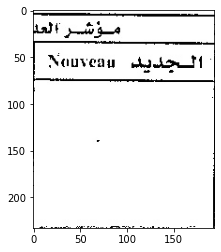

In [25]:
plt.imshow(cv2.cvtColor(new_tri, cv2.COLOR_BGR2RGB))
plt.show()

['No Facture', '83011643', 'asL4', 'Mois', '01/2021', '4', '~']
No Facture 83011643 asL4 Mois 01/2021 4 ~


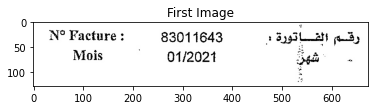

In [99]:
imss=cv2.imread("D4/frags/num_date.jpg")
results = text_reader.readtext(imss )
textt=[]
for (bbox, text, prob) in results:
    textt.append(text)
print(textt)
plt.imshow(imss)
plt.title("First Image");

In [98]:
res_keras=[]
corrected=[]
res_tes=[]
tt=cv2.imread('D4/frags/n_d.jpg')
res_tes=pytesseract.image_to_string(tt,config=config,lang='eng')
#print(res_tes)
res_tes=prepare(res_tes,'tab')
#res_tes=number_correction(res_tes)
print('resultat tesseract: ',res_tes)
res_opus=textract.process('D4/frags/n_d.jpg',method='ocropus')
res_opus=res_opus.decode("utf-8")
res_opus=prepare(res_opus,'tab')
#print(res_opus)
#res_opus=number_correction(res_opus)
print('resultat ocropus: ',res_opus)
predictions = pipeline.recognize([tt])
for prediction in predictions[0]:
    res_keras.append(prepare(prediction[0],'tab'))
#res_keras=' '.join(res_keras)
print('resultat keras',res_keras)

resultat tesseract:  ['N Facture . 83011643  Syg3LaN By', 'Mois 01/2021 et']
resultat ocropus:  ['N Facture . 83011643  Syg3LaN By', 'Mois 01/2021 et']
resultat keras [['no'], ['facture'], ['8301'], ['1643'], ['oila'], ['cs'], ['s'], ['mois'], ['0112021'], ['la']]


In [101]:
import re
def is_valid_number(string):
    pattern = r'^[0-9,.-]+$'
    return re.match(pattern, string) is not None and len(string) > 2
def is_valid_date(string):
    pattern = r'^(0[1-9]|1[0-2])/(\d{4})$'
    return re.match(pattern, string) is not None


In [102]:
for xx in textt:
    if is_valid_number(xx):
        print(xx)

83011643


In [86]:
res_tes

'geo Référence 552610'